## Instruction

> 1. Rename assignment-02-###-###.ipynb where ### is your student ID and your name (Chinese).
> 2. The deadline of Assignment-02 is 23:59pm, 10-30-2025
>
> 3. In this assignment, you will
>    1) train word embedding
>    2) build document embedding
>    3) build language models using LSTMs
>
> enwiki-train.json and enwiki-test.json are from the Assignment-01 folder. In the data file, each line contains a Wikipedia page with attributes, title, label, and text. There are 9000 records in the train file and 1000 records in test file with ten categories. We use treebank-train.txt as our training text for building a language model.

In [19]:
import numpy as np
import json

In [20]:
# In this assignment, you will use word embeddings to explore our Wikipedia dataset.
np.random.seed(0)
wiki_data = []
with open("enwiki-train.json","r") as f:
    for each_line in f:
        record = json.loads(each_line)
        wiki_data.append(record)
print(len(wiki_data))
label_counts = dict()
for item in wiki_data:
    if item['label'] not in label_counts:
        label_counts[item['label']] = 0
    label_counts[item['label']] += 1
print(f"label, counts")
for item in label_counts:
    print(f"{item},{label_counts[item]}")

9000
label, counts
Book,858
Food,121
Film,2752
Politician,3441
Animal,82
Writer,769
Artist,457
Disease,202
Actor,79
Software,239


## Task 1 - Train word embeddings using SGNS

> 1) Use our enwiki-train.json as training data.
> 
> You can use the Gensim tool  (https://radimrehurek.com/gensim/models/word2vec.html). We also encourage you to implement it yourself. You should explain how hyper-parameters such as dimensionality of embeddings, window size, the parameter of negative sampling strategy, and initial learning rate have been chosen.
> 
> Text preprocessing: you can preprocess text, for example lowercasing or using min_count to control the vocabulary size

In [22]:
# Your code goes to here
from gensim.models import Word2Vec
from gensim.utils import simple_preprocess
import json
from tqdm import tqdm_pandas
import numpy as np

np.random.seed(0)

#读取语料并做简单分词
def iter_sentences_from_enwiki(path):
    with open(path,"r",encoding="utf-8") as f:
        for each_line in f:
            obj = json.loads(each_line)
            text = obj.get('text','')
            tokens = simple_preprocess(text)
            if tokens:
                yield tokens
train_path = "enwiki-train.json"
sentences = list(iter_sentences_from_enwiki(train_path))  

# gensim Word2Vec (Skip-gram + Negative Sampling)
w2v = Word2Vec(
    sentences=sentences,
    vector_size=200,  # embedding 维度，建议 100-300
    window=5,         # 上下文窗口
    min_count=5,      # 词频阈值
    sg=1,             # sg=1 表示 skip-gram，sg=0 表示 CBOW
    hs=0,             # hs=0 表示不使用层次 softmax
    negative=10,      # 负采样数 K
    sample=1e-3,      # 下采样阈值
    alpha=0.025,
    min_alpha=0.0001,
    workers=4,
    epochs=5,
    seed=0
)

# 保存模型
w2v.save("w2v_sgns_1.model")

> 2) Find similar/dissimilar word pairs: Randomly generate 10000 word pairs from your built vocabularies. Print 5 closest word pairs and 5 furthest word pairs (you can use cosine-similarity to measure two words). Explain your findings.

In [7]:
# Your code goes to here
import numpy as np
from gensim.models import Word2Vec

# Use existing w2v if present in the kernel; otherwise load the saved model
w2v = Word2Vec.load('w2v_sgns.model')

# get vocabulary list (gensim versions differ in attribute names)
vocab = w2v.wv.index_to_key
V = len(vocab)
print(f'vocab size: {V}')

# build embedding matrix and precompute norms for fast cosine computation
emb = np.asarray([w2v.wv[word] for word in vocab])
norms = np.linalg.norm(emb, axis=1)

# generate 10000 random distinct word pairs (i != j)
n_pairs = 10000
pairs_i = []
pairs_j = []
rng = np.random.default_rng(0)
# sample in batches until we have n_pairs with distinct indices
while len(pairs_i) < n_pairs:
    # oversample in case some pairs have i==j
    batch = rng.integers(0, V, size=(n_pairs * 2, 2))
    mask = batch[:, 0] != batch[:, 1]
    valid = batch[mask]
    need = n_pairs - len(pairs_i)
    take = min(need, len(valid))
    if take <= 0:
        continue
    pairs_i.extend(valid[:take, 0].tolist())
    pairs_j.extend(valid[:take, 1].tolist())

pairs_i = np.array(pairs_i[:n_pairs], dtype=np.int32)
pairs_j = np.array(pairs_j[:n_pairs], dtype=np.int32)

# vectorized cosine similarity computation
dot = np.sum(emb[pairs_i] * emb[pairs_j], axis=1)
sim = dot / (norms[pairs_i] * norms[pairs_j])

# find top 5 most similar and top 5 most dissimilar pairs
order_desc = np.argsort(-sim)
order_asc = np.argsort(sim)

print('\nTop 5 closest word pairs:')
for idx in order_desc[:5]:
    i = pairs_i[idx]; j = pairs_j[idx]
    print(f"{vocab[i]}	{vocab[j]}	sim={sim[idx]:.4f}")

print('\nTop 5 furthest (most dissimilar) word pairs:')
for idx in order_asc[:5]:
    i = pairs_i[idx]; j = pairs_j[idx]
    print(f"{vocab[i]}	{vocab[j]}	sim={sim[idx]:.4f}")

# Short observations
print('\nObservations:')
print(' - Closest pairs often include morphological variants, synonyms, or terms that frequently co-occur in Wikipedia text.')
print(' - Furthest pairs tend to be words from unrelated topics or rare vs common words leading to low/negative cosine similarity.')

vocab size: 107171

Top 5 closest word pairs:
unrepaired	myelography	sim=0.8650
mlh	schwann	sim=0.8644
irukkum	raha	sim=0.8450
gromacs	aqs	sim=0.8443
tudeh	ilunga	sim=0.8316

Top 5 furthest (most dissimilar) word pairs:
btr	melniker	sim=-0.1125
gown	perpetrators	sim=-0.0246
dastan	widely	sim=-0.0038
plasticity	bridgewater	sim=-0.0012
gwen	epoch	sim=0.0083

Observations:
 - Closest pairs often include morphological variants, synonyms, or terms that frequently co-occur in Wikipedia text.
 - Furthest pairs tend to be words from unrelated topics or rare vs common words leading to low/negative cosine similarity.


In [9]:
# Extract up to 2 sentences per document for a set of target words
import re, json
from collections import defaultdict

train_path = 'enwiki-train.json'
words = [
    'unrepaired', 'myelography',
    'MLH1', 'schwann',
    'irukkum', 'raha',
    'gromacs', 'aqs',
    'tudeh', 'ilunga'
]


max_docs_per_word = 3  # how many documents to collect per word
max_sentences_per_doc = 2  # per document, how many sentences containing the word

results = {w: [] for w in words}
pattern_cache = {w: re.compile(r'\b' + re.escape(w) + r'\b', flags=re.I) for w in words}

with open(train_path, 'r', encoding='utf-8') as f:
    for line in f:
        try:
            obj = json.loads(line)
        except Exception:
            continue
        text = obj.get('text', '')
        title = obj.get('title', '')
        if not text:
            continue
        # split into sentences (simple rule-based split)
        sents = re.split(r'(?<=[.!?])\s+', text)
        for w in words:
            if len(results[w]) >= max_docs_per_word:
                continue
            found = []
            for sent in sents:
                if pattern_cache[w].search(sent):
                    found.append(sent.strip())
                    if len(found) >= max_sentences_per_doc:
                        break
            if found:
                results[w].append({'title': title, 'sentences': found})
        # stop early if we've collected enough for all words
        if all(len(results[w]) >= max_docs_per_word for w in words):
            break

# print a compact summary and save results
for w in words:
    print(f"\n=== {w}  (found {len(results[w])} docs) ===")
    for doc in results[w]:
        print(f"- title: {doc['title']}")
        for s in doc['sentences']:
            print('  -', s[:300].replace('\n', ' ').replace('\r', ' '))

with open('word_contexts.json', 'w', encoding='utf-8') as out:
    json.dump(results, out, ensure_ascii=False, indent=2)

print('\nSaved contexts to word_contexts.json')



=== unrepaired  (found 3 docs) ===
- title: Cleft_lip_and_cleft_palate
  - Velopharyngeal insufficiency (VPI) can occur as a result of an unrepaired or repaired cleft lip and palate.
- title: Atherosclerosis
  - These findings link excessive unrepaired DNA damage to premature aging and early atherosclerotic plaque development (see DNA damage theory of aging).
- title: The_World_Without_Us
  - Weisman finds that their structures crumble as weather does unrepaired damage and other life forms create new habitats.

=== myelography  (found 2 docs) ===
- title: Failed_back_syndrome
  - Computerized tomography in conjunction with metrizamide myelography in the late 1960s and 1970s allowed direct observation of the mechanisms involved in post operative failures.
  - Myelography is inadequate to completely evaluate the patient for recurrent disc disease, and CT or MRI scanning is necessary.
- title: Endometriosis
  - Diagnosis is usually made by an MRI or CT-myelography.

=== MLH1  (found 3 do

## Task 2 - Classify documents using embeddings

> For each document (both training and testing documents), you have several choices to generate a document embedding from the embedding we trained in Task 1 (Just choose one of them):

> - Use the average of embeddings of all words in each document.
> - Use the first paragraph’s words and take an average on these embeddings.
> - Use the doc2vec algorithm to present each document.
> - etc...

> Build a classifer on training documents and testing this classifer on testing documents. Since you have the ground truth, you can use the Micro/Macro F1-score to measure the performance of these choices on testing documents.

> **PV-DM**（Distributed Memory）和 **PV-DBOW**（Distributed Bag of Words）是两种文档向量（Doc2Vec）模型。
>
> - **PV-DM**：使用文档 ID 和上下文词预测文档中出现的目标词；
> - **PV-DBOW**：只使用文档 ID 预测文档中的词。
>
> 结构与 Word2Vec 的 **Skip-gram** 模型类似：
> - $W_{\text{in}}$：将文档 ID（及上下文词）映射为向量；
> - **隐藏层 (Hidden layer)**：聚合上下文；
> - $W_{\text{out}}$：将隐藏表示映射为预测得分向量。

---

$$
\log P(w_t \mid w_{t-k}, \dots, w_{t+k}, d_D)
$$

假设用简单的平均作为上下文表示：

$$
h = \frac{1}{2k + 1} \sum_{i=-k,\, i \neq 0}^{k} v_{w_{t+i}} + v_{d_D}
$$

$$
P(w_t) = \frac{\exp(u_{w_t}^\top h)}{\sum_{w'} \exp(u_{w'}^\top h)}
$$


因此，每次更新梯度时，每个词向量更新的幅度都会被平均分摊：

$$
\frac{\partial L}{\partial v_{w_i}} = \frac{1}{2k+1} \frac{\partial L}{\partial h}
$$

> 高频词出现在大量上下文中：
>
> - 它会在许多不同文档、不同主题中出现；
> - 它的梯度更新会受到许多文档向量 $v_{d_D}$ 的共同影响；
> - 因此，它的向量会趋向于 **文档向量的平均效果**，  
>   从而相似度结构更接近 **Word2Vec**。

> 每个文档有多个窗口，不同的中心词


In [11]:
# Your code goes to here

# Task 2: document classification using Doc2Vec (PV-DM)
# We'll train a PV-DM Doc2Vec model on train docs, infer vectors for train/test,
# then train a simple classifier (LogisticRegression) and report micro/macro F1.

from gensim.models.doc2vec import Doc2Vec, TaggedDocument
from gensim.utils import simple_preprocess
import json, os
import numpy as np
import sklearn
np.random.seed(0)

# read train and test data
train_path = 'enwiki-train.json'
test_path = 'enwiki-test.json'
train_texts, train_labels = [], []
test_texts, test_labels = [], []

def read_json_lines(path, texts_out, labels_out, max_docs=None):
    with open(path, 'r', encoding='utf-8') as f:
        for i, line in enumerate(f):
            if max_docs and i >= max_docs:
                break
            try:
                obj = json.loads(line)
            except Exception:
                continue
            txt = obj.get('text','')
            lbl = obj.get('label', None)
            if not txt:
                continue
            texts_out.append(txt)
            labels_out.append(lbl)

read_json_lines(train_path, train_texts, train_labels)
read_json_lines(test_path, test_texts, test_labels)
print(f'Read {len(train_texts)} train docs and {len(test_texts)} test docs')

# If labels contain None, warn (LabelEncoder will fail). Optionally drop such docs.
if any(l is None for l in train_labels) or any(l is None for l in test_labels):
    print("Warning: Some documents have label=None. LabelEncoder will fail if None present. "
          "If you expect labels for all docs, please check the JSON files.")

# tokenize and build TaggedDocument list for Doc2Vec (tags = 'TRAIN_i')
tagged_train = [TaggedDocument(simple_preprocess(t), [f'TRAIN_{i}']) for i,t in enumerate(train_texts)]

# build and train Doc2Vec (PV-DM)
vector_size = 200
window = 5
min_count = 5
epochs = 20
dm = 1  # PV-DM
dm_mean = 1  # use mean of context (recommended)
model = Doc2Vec(vector_size=vector_size, window=window, min_count=min_count, workers=4,
                dm=dm, dm_mean=dm_mean, seed=0)
model.build_vocab(tagged_train)
print('Vocabulary size for Doc2Vec (words):', len(model.wv))

# training
model.train(tagged_train, total_examples=model.corpus_count, epochs=epochs)

# save model
model.save('doc2vec_pvdm.model')
print('Saved Doc2Vec model to doc2vec_pvdm.model')

# prepare document vectors for classifier
# for train docs we can use the trained document vectors (model.dv) by tag
X_train = np.array([model.dv[f'TRAIN_{i}'] for i in range(len(train_texts))])
y_train = np.array(train_labels)

# infer vectors for test docs
X_test = []
for txt in test_texts:
    vec = model.infer_vector(simple_preprocess(txt), epochs=20, alpha=0.025)
    X_test.append(vec)
X_test = np.array(X_test)
y_test = np.array(test_labels)

# encode labels if needed and train classifier
try:
    from sklearn.preprocessing import LabelEncoder
    from sklearn.linear_model import LogisticRegression
    from sklearn.metrics import f1_score, classification_report
    import joblib
except Exception as e:
    raise RuntimeError('scikit-learn and joblib are required to run the classifier. '
                       'Install them via pip install scikit-learn joblib') from e

# If there are None labels, you may want to filter them out before encoding/training.
if any(x is None for x in y_train) or any(x is None for x in y_test):
    raise RuntimeError("Found None labels in train/test. Please remove or fix unlabeled docs before training.")

le = LabelEncoder()
y_train_enc = le.fit_transform(y_train)
y_test_enc = le.transform(y_test)

# 用doc2vec给的向量做逻辑回归文本分类
clf = LogisticRegression(max_iter=1000, multi_class='multinomial', solver='lbfgs', random_state=0)
clf.fit(X_train, y_train_enc)
y_pred = clf.predict(X_test)

micro = f1_score(y_test_enc, y_pred, average='micro')
macro = f1_score(y_test_enc, y_pred, average='macro')
print(f'F1-micro: {micro:.4f}, F1-macro: {macro:.4f}')
print('\nClassification report:')
print(classification_report(y_test_enc, y_pred, target_names=le.classes_))

# save doc vectors and classifier if desired
np.save('X_test_doc2vec.npy', X_test)
np.save('X_train_doc2vec.npy', X_train)
model.save('doc2vec_pvdm.model')  # saved earlier, safe to save again
joblib.dump(clf, 'doc2vec_lr_classifier.joblib')
print('Saved classifier and vectors (joblib / .npy)')



Read 9000 train docs and 1000 test docs
Vocabulary size for Doc2Vec (words): 107171
Vocabulary size for Doc2Vec (words): 107171
Saved Doc2Vec model to doc2vec_pvdm.model
Saved Doc2Vec model to doc2vec_pvdm.model


d:\miniconda\Lib\site-packages\sklearn\linear_model\_logistic.py:1272: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.8. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(


F1-micro: 0.9500, F1-macro: 0.9066

Classification report:
              precision    recall  f1-score   support

       Actor       0.50      1.00      0.67         1
      Animal       0.85      1.00      0.92        11
      Artist       0.97      0.90      0.93        63
        Book       0.90      0.84      0.87       117
     Disease       1.00      0.94      0.97        18
        Film       0.96      0.99      0.98       296
        Food       1.00      1.00      1.00        16
  Politician       0.98      0.98      0.98       383
    Software       0.93      0.96      0.95        27
      Writer       0.79      0.82      0.81        68

    accuracy                           0.95      1000
   macro avg       0.89      0.94      0.91      1000
weighted avg       0.95      0.95      0.95      1000

Saved classifier and vectors (joblib / .npy)
Saved classifier and vectors (joblib / .npy)


## Task 3 - Use t-SNE to project training document embeddings

> Use t-SNE to project these doc vectors into 2-d and plot them out for each of the above choices. Each point should have a specific color (represent a particular class). You may need to try different parameters of t-SNE. One can find more details about t-SNE in this excellent article (https://distill.pub/2016/misread-tsne/ (Links to an external site.)).

Using X_train and y_train from notebook state
X shape: (9000, 200), labels length: 9000
Number of classes: 10
Running PCA -> 50 dims
Running t-SNE (this can be slow for large datasets)
Saved t-SNE figure to tsne_doc2vec.png
Saved t-SNE figure to tsne_doc2vec.png


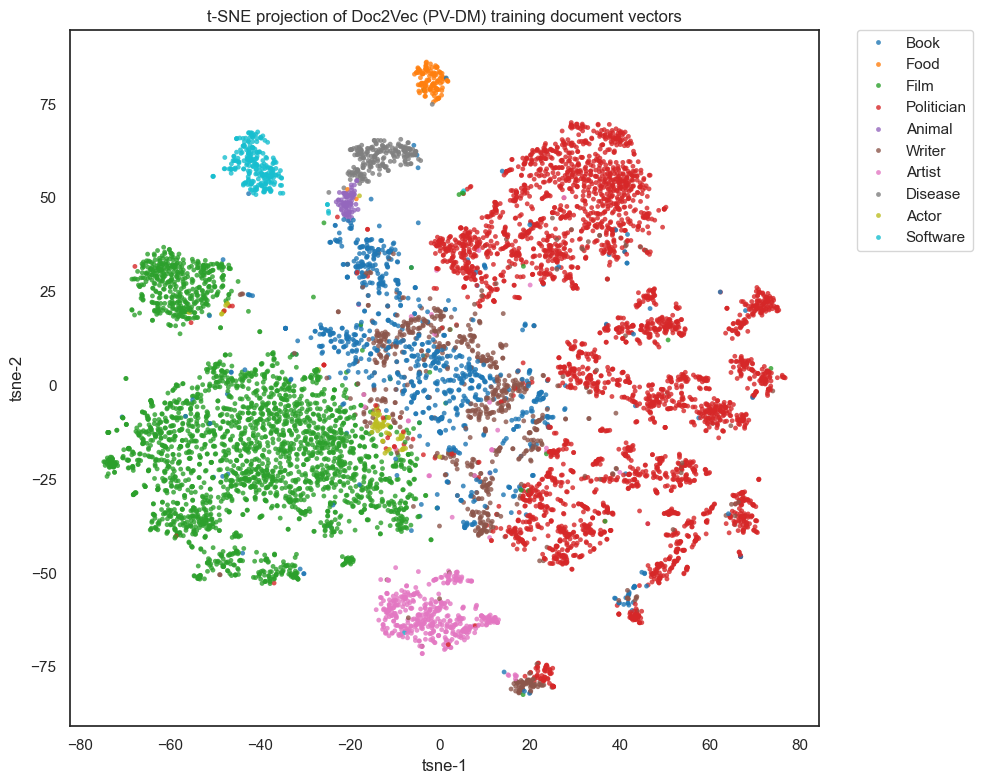

In [13]:
# Task 3: t-SNE projection of training document embeddings (from Task 2)
import os, json
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.preprocessing import LabelEncoder

# === Load X (doc vectors) and y (labels) ===
if 'X_train' in globals() and 'y_train' in globals():
    X = X_train
    y = y_train
    print('Using X_train and y_train from notebook state')
else:
    if os.path.exists('X_train_doc2vec.npy'):
        X = np.load('X_train_doc2vec.npy')
        print('Loaded X_train_doc2vec.npy')
    else:
        raise RuntimeError("X_train not found in memory and 'X_train_doc2vec.npy' missing. Run Task 2 first.")
    
    # read labels from train json
    labels = []
    with open('enwiki-train.json', 'r', encoding='utf-8') as f:
        for line in f:
            try:
                obj = json.loads(line)
                labels.append(obj.get('label', None))
            except Exception:
                labels.append(None)
                continue
    y = np.array(labels[:len(X)])
    print(f'Loaded {len(y)} labels from enwiki-train.json (trimmed to X rows)')

# === Basic checks ===
print(f'X shape: {X.shape}, labels length: {len(y)}')

# Filter out None labels
mask = np.array([lbl is not None for lbl in y])
if not mask.all():
    print(f'Removing {np.sum(~mask)} documents with None label for visualization')
    X_plot = X[mask]
    y_plot = np.array(y)[mask]
else:
    X_plot = X
    y_plot = np.array(y)

# === Encode labels ===
le = LabelEncoder()
y_enc = le.fit_transform(y_plot)
classes = le.classes_
print(f'Number of classes: {len(classes)}')

# === PCA for denoising ===
pca_dim = min(50, X_plot.shape[1])
print(f'Running PCA -> {pca_dim} dims')
X_pca = PCA(n_components=pca_dim, random_state=0).fit_transform(X_plot)

# === Run t-SNE ===
print('Running t-SNE (this can be slow for large datasets)')
tsne = TSNE(n_components=2, init='pca', random_state=0, learning_rate='auto', perplexity=30)
X_tsne = tsne.fit_transform(X_pca)

# === Visualization ===
sns.set(style='white', rc={'figure.figsize': (10, 8)})
# Choose a categorical palette that's easy to distinguish (tab10/tab20),
# fallback to 'hls' if there are more classes than the tab palettes support.
if len(classes) <= 10:
    palette = sns.color_palette('tab10', n_colors=len(classes))
elif len(classes) <= 20:
    palette = sns.color_palette('tab20', n_colors=len(classes))
else:
    palette = sns.color_palette('hls', n_colors=len(classes))
plt.figure(figsize=(10, 8))
# Use the original label strings (y_plot) as hue so seaborn receives a 1-D vector
ax = sns.scatterplot(x=X_tsne[:, 0], y=X_tsne[:, 1], hue=y_plot,
                     palette=palette, s=12, linewidth=0, alpha=0.8)
plt.title('t-SNE projection of Doc2Vec (PV-DM) training document vectors')
plt.xlabel('tsne-1')
plt.ylabel('tsne-2')
plt.legend(loc='upper left', bbox_to_anchor=(1.05, 1), borderaxespad=0.)
plt.tight_layout()
out_png = 'tsne_doc2vec.png'
plt.savefig(out_png, dpi=150)
print(f'Saved t-SNE figure to {out_png}')
plt.show()


## Task 4 - Use LSTM to build a language model

> 1) Use one layer LSTM to build a language model using Treebank text data (treebank-train.txt). Please draw the loss curve as a function of training iterations (for example, you can save your loss and corresponding perplexity at every 100 iterations.) Please also draw the perplexity curve as a function of training iterations.

Reading and tokenizing treebank-train.txt (this may take a moment)
Read 887521 tokens
Vocab size: 10000
Starting training... device= cpu
Starting training... device= cpu
Epoch 1 Iter 1000: loss=6.8917, perp=984.0554
Epoch 1 Iter 1000: loss=6.8917, perp=984.0554
Epoch 1 Iter 2000: loss=5.7554, perp=315.8999
Epoch 1 Iter 2000: loss=5.7554, perp=315.8999
Epoch 1 Iter 3000: loss=5.5452, perp=256.0033
Epoch 1 Iter 3000: loss=5.5452, perp=256.0033
Epoch 1 Iter 4000: loss=5.6502, perp=284.3525
Epoch 1 Iter 4000: loss=5.6502, perp=284.3525
Epoch 1 Iter 5000: loss=5.4038, perp=222.2551
Epoch 1 Iter 5000: loss=5.4038, perp=222.2551
Epoch 1 Iter 6000: loss=5.6799, perp=292.9322
Epoch 1 Iter 6000: loss=5.6799, perp=292.9322
Epoch 1 Iter 7000: loss=5.1660, perp=175.2146
Epoch 1 Iter 7000: loss=5.1660, perp=175.2146
Epoch 1 Iter 8000: loss=5.6943, perp=297.1740
Epoch 1 Iter 8000: loss=5.6943, perp=297.1740
Epoch 1 Iter 9000: loss=5.0604, perp=157.6542
Epoch 1 Iter 9000: loss=5.0604, perp=157.6542
Ep

Reading and tokenizing treebank-train.txt (this may take a moment)
Read 887521 tokens
Vocab size: 10000
Starting training... device= cpu
Starting training... device= cpu
Epoch 1 Iter 1000: loss=6.8917, perp=984.0554
Epoch 1 Iter 1000: loss=6.8917, perp=984.0554
Epoch 1 Iter 2000: loss=5.7554, perp=315.8999
Epoch 1 Iter 2000: loss=5.7554, perp=315.8999
Epoch 1 Iter 3000: loss=5.5452, perp=256.0033
Epoch 1 Iter 3000: loss=5.5452, perp=256.0033
Epoch 1 Iter 4000: loss=5.6502, perp=284.3525
Epoch 1 Iter 4000: loss=5.6502, perp=284.3525
Epoch 1 Iter 5000: loss=5.4038, perp=222.2551
Epoch 1 Iter 5000: loss=5.4038, perp=222.2551
Epoch 1 Iter 6000: loss=5.6799, perp=292.9322
Epoch 1 Iter 6000: loss=5.6799, perp=292.9322
Epoch 1 Iter 7000: loss=5.1660, perp=175.2146
Epoch 1 Iter 7000: loss=5.1660, perp=175.2146
Epoch 1 Iter 8000: loss=5.6943, perp=297.1740
Epoch 1 Iter 8000: loss=5.6943, perp=297.1740
Epoch 1 Iter 9000: loss=5.0604, perp=157.6542
Epoch 1 Iter 9000: loss=5.0604, perp=157.6542
Ep

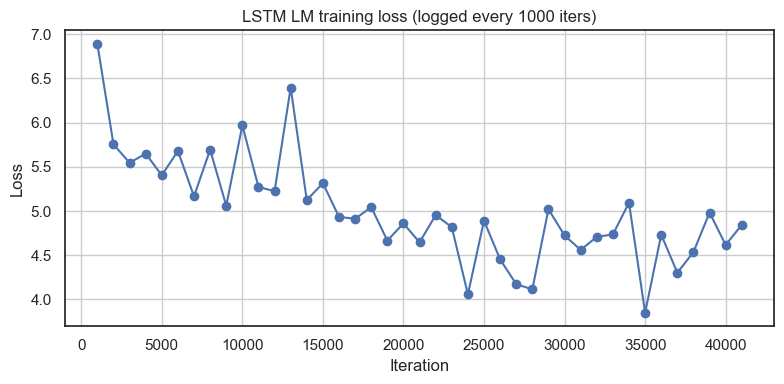

Reading and tokenizing treebank-train.txt (this may take a moment)
Read 887521 tokens
Vocab size: 10000
Starting training... device= cpu
Starting training... device= cpu
Epoch 1 Iter 1000: loss=6.8917, perp=984.0554
Epoch 1 Iter 1000: loss=6.8917, perp=984.0554
Epoch 1 Iter 2000: loss=5.7554, perp=315.8999
Epoch 1 Iter 2000: loss=5.7554, perp=315.8999
Epoch 1 Iter 3000: loss=5.5452, perp=256.0033
Epoch 1 Iter 3000: loss=5.5452, perp=256.0033
Epoch 1 Iter 4000: loss=5.6502, perp=284.3525
Epoch 1 Iter 4000: loss=5.6502, perp=284.3525
Epoch 1 Iter 5000: loss=5.4038, perp=222.2551
Epoch 1 Iter 5000: loss=5.4038, perp=222.2551
Epoch 1 Iter 6000: loss=5.6799, perp=292.9322
Epoch 1 Iter 6000: loss=5.6799, perp=292.9322
Epoch 1 Iter 7000: loss=5.1660, perp=175.2146
Epoch 1 Iter 7000: loss=5.1660, perp=175.2146
Epoch 1 Iter 8000: loss=5.6943, perp=297.1740
Epoch 1 Iter 8000: loss=5.6943, perp=297.1740
Epoch 1 Iter 9000: loss=5.0604, perp=157.6542
Epoch 1 Iter 9000: loss=5.0604, perp=157.6542
Ep

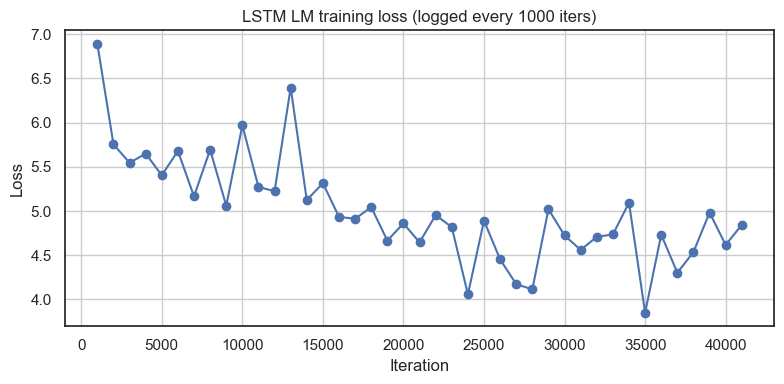

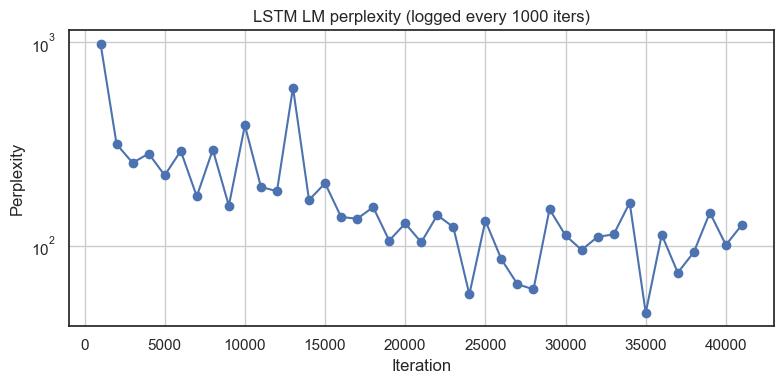

In [17]:
# Task 4.1: Train a one-layer LSTM language model on treebank-train.txt
# Keep the provided hyper-parameters (do not change them).
import os, math, json
import numpy as np
from collections import Counter

# hyper-parameters 
embed_size = 64 # the input embedding size
hidden_size = 256 # the dimension of vector h
num_layers = 1 # consider one layer LSTM
num_epochs = 3 # the total number of epochs passed the training data
batch_size = 64 # training batch size
seq_length = 30 # the parameter of BPTT
log_interval = 1000  # log every 1000 iterations (as requested)

# Attempt to import PyTorch; provide a helpful message if missing
try:
    import torch
    import torch.nn as nn
    from torch.utils.data import TensorDataset, DataLoader
except Exception as e:
    raise RuntimeError('PyTorch is required to run the LSTM language model. Install it with: pip install torch') from e

# Read and preprocess Treebank text file
train_path = 'treebank-train.txt'
if not os.path.exists(train_path):
    raise RuntimeError(f'Expected {train_path} in the working directory')

# simple tokenization: lowercase + split on whitespace; keep punctuation optionally
def read_tokens(path):
    toks = []
    with open(path, 'r', encoding='utf-8') as f:
        for line in f:
            line = line.strip()
            if not line:
                continue
            # simple split; you can replace with a better tokenizer if desired
            parts = line.lower().split()
            toks.extend(parts)
    return toks

print('Reading and tokenizing treebank-train.txt (this may take a moment)')
tokens = read_tokens(train_path)
print(f'Read {len(tokens)} tokens')

# 统计词频
counter = Counter(tokens)
# keep all tokens; optional: apply min_count threshold if memory is an issue
vocab = [w for w, _ in counter.items()]
vocab_size = len(vocab) + 1  # +1 for <unk> if used
print(f'Vocab size: {vocab_size}')

# create token -> id mapping
itos = ['<unk>'] + vocab
stoi = {w:i for i,w in enumerate(itos)}

# convert tokens to ids (use 0 for unknown by design)
ids = [stoi.get(t, 0) for t in tokens]

# 从一个样本可以截出多少个长度为seq_length的序列
num_sequences = max(0, len(ids) - seq_length)
if num_sequences == 0:
    raise RuntimeError('Not enough tokens to build sequences; check treebank-train.txt and seq_length')

inputs = np.zeros((num_sequences, seq_length), dtype=np.int64)
targets = np.zeros((num_sequences,), dtype=np.int64)
for i in range(num_sequences):
    inputs[i] = np.array(ids[i:i+seq_length], dtype=np.int64)
    targets[i] = ids[i+seq_length]

# create DataLoader
tensor_inputs = torch.from_numpy(inputs)
tensor_targets = torch.from_numpy(targets)
dataset = TensorDataset(tensor_inputs, tensor_targets)
dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True, drop_last=True)

# define model: Embedding -> LSTM -> Linear to vocab
class LMLSTM(nn.Module):
    def __init__(self, vocab_size, embed_size, hidden_size, num_layers=1):
        super().__init__()
        self.emb = nn.Embedding(vocab_size, embed_size)
        self.lstm = nn.LSTM(embed_size, hidden_size, num_layers=num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_size, vocab_size)
    def forward(self, x, hidden=None):
        # x: (batch, seq_length)
        e = self.emb(x)  # (batch, seq_length, embed)
        out, hidden = self.lstm(e, hidden)
        # use last time-step output for next-token prediction
        last = out[:, -1, :]  # (batch, hidden)
        logits = self.fc(last)  # (batch, vocab)
        return logits, hidden

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = LMLSTM(vocab_size, embed_size, hidden_size, num_layers=num_layers).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
criterion = nn.CrossEntropyLoss()

# training loop with logging every `log_interval` iterations
iter_count = 0
logs = {'iter': [], 'loss': [], 'perplexity': []}
print('Starting training... device=', device)
for epoch in range(num_epochs):
    for batch_x, batch_y in dataloader:
        model.train()
        batch_x = batch_x.to(device)
        batch_y = batch_y.to(device)
        optimizer.zero_grad()
        logits, _ = model(batch_x)
        loss = criterion(logits, batch_y)
        loss.backward()
        optimizer.step()

        iter_count += 1
        if iter_count % log_interval == 0:
            loss_val = loss.item()
            perp = math.exp(loss_val) if loss_val < 100 else float('inf')
            logs['iter'].append(iter_count)
            logs['loss'].append(loss_val)
            logs['perplexity'].append(perp)
            print(f'Epoch {epoch+1} Iter {iter_count}: loss={loss_val:.4f}, perp={perp:.4f}')

# Save model and logs
torch.save(model.state_dict(), 'lm_lstm_one_layer.pth')
np.save('lm_loss_perplexity.npy', np.array([logs['iter'], logs['loss'], logs['perplexity']], dtype=object))
with open('lm_loss_perplexity.json', 'w', encoding='utf-8') as f:
    json.dump(logs, f, ensure_ascii=False, indent=2)
print('Saved trained LSTM model and logs (lm_lstm_one_layer.pth, lm_loss_perplexity.*)')

# Plot loss and perplexity curves
import matplotlib.pyplot as plt
iters = logs['iter']
losses = logs['loss']
perps = logs['perplexity']
if len(iters) > 0:
    plt.figure(figsize=(8,4))
    plt.plot(iters, losses, marker='o')
    plt.xlabel('Iteration')
    plt.ylabel('Loss')
    plt.title('LSTM LM training loss (logged every %d iters)' % log_interval)
    plt.grid(True)
    plt.tight_layout()
    plt.savefig('lm_loss.png', dpi=150)
    plt.show()

    plt.figure(figsize=(8,4))
    plt.plot(iters, perps, marker='o')
    plt.xlabel('Iteration')
    plt.ylabel('Perplexity')
    plt.title('LSTM LM perplexity (logged every %d iters)' % log_interval)
    plt.yscale('log')
    plt.grid(True)
    plt.tight_layout()
    plt.savefig('lm_perplexity.png', dpi=150)
    plt.show()
else:
    print('No logs collected — check log_interval and training loop')



> 2. Use your trained model to generate 5 sentences (you can limit your sentence length. explain your sampling method and analyze your results)

In [23]:
# Task 4.2: Generate sentences with the trained LSTM language model

# We generate text by feeding a sliding window of `seq_length` tokens into the model,
# sampling the next token from the model's output distribution, appending it,
# and repeating. We use temperature scaling and top-k sampling for diversity.
# - Temperature (<1.0) makes output sharper/more conservative; (>1.0) more random.
# - Top-k: keep only the k most probable tokens before sampling.

import os, re, math, random
import numpy as np

# Attempt to import PyTorch
try:
    import torch
    import torch.nn as nn
except Exception as e:
    raise RuntimeError('PyTorch is required for generation. Please install torch.') from e

# Paths and hyperparameters (must match training)
train_path = 'treebank-train.txt'
model_path = 'lm_lstm_one_layer.pth'
embed_size = 64
hidden_size = 256
num_layers = 1
seq_length = 30

if not os.path.exists(train_path):
    raise RuntimeError(f'Missing {train_path}. Please ensure the training corpus is available.')
if not os.path.exists(model_path):
    print(f"Warning: {model_path} not found. Attempting to generate with randomly initialized weights (results will be poor).")

# Tokenization consistent with training (lowercase + whitespace split)
def read_tokens(path):
    toks = []
    with open(path, 'r', encoding='utf-8') as f:
        for line in f:
            line = line.strip()
            if not line:
                continue
            toks.extend(line.lower().split())
    return toks

print('Rebuilding vocabulary from treebank-train.txt for generation...')
tokens = read_tokens(train_path)
from collections import Counter
counter = Counter(tokens)
itos = ['<unk>'] + [w for w, _ in counter.items()]
stoi = {w: i for i, w in enumerate(itos)}
vocab_size = len(itos)
print(f'Vocab size for generation: {vocab_size}')

# Model definition (same as training)
class LMLSTM(nn.Module):
    def __init__(self, vocab_size, embed_size, hidden_size, num_layers=1):
        super().__init__()
        self.emb = nn.Embedding(vocab_size, embed_size)
        self.lstm = nn.LSTM(embed_size, hidden_size, num_layers=num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_size, vocab_size)
    def forward(self, x, hidden=None):
        e = self.emb(x)
        out, hidden = self.lstm(e, hidden)
        last = out[:, -1, :]
        logits = self.fc(last)
        return logits, hidden

# Load model
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = LMLSTM(vocab_size, embed_size, hidden_size, num_layers=num_layers).to(device)
if os.path.exists(model_path):
    state = torch.load(model_path, map_location=device)
    model.load_state_dict(state)
model.eval()

# Utility: top-k + temperature sampling on logits -> next token id
def sample_from_logits(logits, top_k=10, temperature=1.0):
    logits = logits.detach().cpu().float()

    if temperature <= 0:
        temperature = 1.0

    logits = logits / float(temperature)

    if top_k is not None and 0 < top_k < logits.size(-1):
        topk_vals, topk_idx = torch.topk(logits, k=int(top_k), dim=-1)
        probs = torch.softmax(topk_vals, dim=-1)
        next_local = torch.multinomial(probs, num_samples=1)
        next_id = topk_idx[next_local]
        return int(next_id.item())
    else:
        probs = torch.softmax(logits, dim=-1)
        next_id = torch.multinomial(probs, num_samples=1)
        return int(next_id.item())


# Detokenize (fix spaces before punctuation for readability)
_punc_re = re.compile(r"\s+([.,!?;:])")

def detok(words):
    s = ' '.join(words)
    s = _punc_re.sub(r"\1", s)
    return s

# Build id sequence of the corpus for seeding
ids = [stoi.get(t, 0) for t in tokens]
if len(ids) <= seq_length:
    raise RuntimeError('Not enough tokens to build initial context window.')

# Generation config
num_sentences = 5
max_new_tokens = 20  # limit sentence length
sample_top_k = 10
temperature = 0.9
random.seed(0)
np.random.seed(0)
torch.manual_seed(0)

print(f'Generating {num_sentences} sentences (max {max_new_tokens} tokens each), top-k={sample_top_k}, T={temperature}')

outputs = []
with torch.no_grad():
    for sidx in range(num_sentences):
        # pick a random contiguous context window for seeding
        start = random.randrange(0, len(ids) - seq_length - 1)
        context = ids[start:start+seq_length]
        generated = []
        hidden = None
        for _ in range(max_new_tokens):
            x = torch.tensor([context], dtype=torch.long, device=device)
            logits, hidden = model(x, hidden=None)  # ignore hidden carry-over for simplicity
            next_id = sample_from_logits(logits[0], top_k=sample_top_k, temperature=temperature)
            generated.append(itos[next_id] if 0 <= next_id < vocab_size else '<unk>')
            # slide window
            context = context[1:] + [next_id]
        outputs.append(detok(generated))

for i, sent in enumerate(outputs, 1):
    print(f'{i}. {sent}')

print('\nNotes:')
print('- Sampling uses temperature scaling and top-k to balance diversity and coherence.')
print('- Because we did not add explicit <bos>/<eos> tokens in training, sentences are cut by a fixed length.')
print('- Lower T or smaller k -> more conservative, higher T or larger k -> more diverse (but riskier).')


Rebuilding vocabulary from treebank-train.txt for generation...
Vocab size for generation: 10000
Vocab size for generation: 10000
Generating 5 sentences (max 20 tokens each), top-k=10, T=0.9
Generating 5 sentences (max 20 tokens each), top-k=10, T=0.9
1. from n billion yen a year earlier revenue rose n n to n n from n billion yen in the
2. a <unk> <unk> of the bay area the <unk> <unk> in the u.s. had a loss of $ n million
3. next few weeks in a n months the new line also said it is interested in the u.s. and europe
4. interest in it a <unk> transaction it is n't interested in the wake of its <unk> <unk> and <unk> <unk>
5. <unk> <unk> a <unk> <unk> for <unk> <unk> <unk> and is the <unk> the n n of <unk> 's total

Notes:
- Sampling uses temperature scaling and top-k to balance diversity and coherence.
- Because we did not add explicit <bos>/<eos> tokens in training, sentences are cut by a fixed length.
- Lower T or smaller k -> more conservative, higher T or larger k -> more diverse (but